## Help Twitter Combat Hate Speech Using NLP and Machine Learning.
Course-end Project 1

#### DESCRIPTION

Using NLP and ML, make a model to identify hate speech (racist or sexist tweets) in Twitter.

#### PROBLEM STATEMENT:  

Twitter is the biggest platform where anybody and everybody can have their views heard. Some of these voices spread hate and negativity. Twitter is wary of its platform being used as a medium  to spread hate. 

You are a data scientist at Twitter, and you will help Twitter in identifying the tweets with hate speech and removing them from the platform. You will use NLP techniques, perform specific cleanup for tweets data, and make a robust model.

#### DOMAIN: Social Media

Analysis to be done: Clean up tweets and build a classification model by using NLP techniques, cleanup specific for tweets data, regularization and hyperparameter tuning using stratified k-fold and cross validation to get the best model.

#### CONTENT: 

id: identifier number of the tweet

Label: 0 (non-hate) /1 (hate)

Tweet: the text in the tweet



## Importing libraries

In [ ]:
# importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# NLP libraries
import regex as re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction import text 
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from nltk.probability import FreqDist

# modeling libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from collections import Counter
from sklearn import metrics, utils, model_selection, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, plot_confusion_matrix, classification_report


In [ ]:
#read the data
df = pd.read_csv('TwitterHate.csv')

## Exploratory Data Analysis

In [ ]:
df.shape

(31962, 3)

In [ ]:
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,31962.0,15981.500000,9226.778988,1.0,7991.25,15981.5,23971.75,31962.0
label,31962.0,0.070146,0.255397,0.0,0.00,0.0,0.00,1.0


In [ ]:
df.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [ ]:
df['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

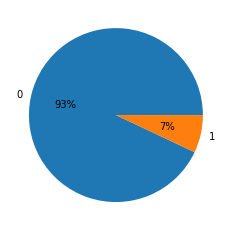

In [ ]:
label=[0,1]
plt.pie(df.label.value_counts(),labels=label, autopct='%1.0f%%')
plt.show()

Imbalanced data containing 0's and 1's in a ratio of 1:13 

## Text Preprocessing

In [ ]:
def clean_text(text):
    '''Make text lowercase, remove punctuation, mentions, hashtags and words containing numbers.'''
    # make text lowercase
    text = text.lower()
    # removing text within brackets
    text = re.sub('\[.*?\]', '', text)
    # removing text within parentheses
    text = re.sub('\(.*?\)', '', text)
    # removing numbers
    text = re.sub('\w*\d\w*', '', text)
    # if there's more than 1 whitespace, then make it just 1
    text = re.sub('\s+', ' ', text)
    # if there's a new line, then make it a whitespace
    text = re.sub('\n', ' ', text)
    # removing any quotes
    text = re.sub('\"+', '', text)
    # removing &amp;
    text = re.sub('(\&amp\;)', '', text)
    # removing any usernames
    text = re.sub('(@[^\s]+)', '', text)
    # removing any hashtags
    text = re.sub('(#[^\s]+)', '', text)
    # remove `rt` for retweet
    text = re.sub('(rt)', '', text)
    # getting rid of `httptco`
    text = re.sub('(httptco)', '', text)
    return text


In [ ]:
df["tweet"] = df["tweet"].apply(clean_text)

In [ ]:
df['tweet']

0          when a father is dysfunctional and is so sel...
1          thanks for  credit i can't use cause they do...
2                                      bihday your majesty
3         i love u take with u all the time in urð±!!...
4                                 factsguide: society now 
                               ...                        
31957    ate  isz that youuu?ððððððð...
31958     to see nina turner on the airwaves trying to ...
31959    listening to sad songs on a monday morning otw...
31960                     vandalised in in   condemns act 
31961                           thank you  for you follow 
Name: tweet, Length: 31962, dtype: object

In [ ]:
#tokenzing the data
tokenizer = TweetTokenizer(preserve_case=True)
df['tweet'] = df['tweet'].apply(tokenizer.tokenize)

In [ ]:
df.head(3)

,id,label,tweet
0,1,0,"[when, a, father, is, dysfunctional, and, is, ..."
1,2,0,"[thanks, for, credit, i, can't, use, cause, th..."
2,3,0,"[bihday, your, majesty]"


In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
#stopwords
stop_words = stopwords.words('english')

#add additional stop words to be removed from the text
additional_list = ['amp','rt','u',"can't",'ur']

for words in additional_list:
    stop_words.append(words)

In [ ]:
stop_words[0:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [ ]:
#removing the stopwords
def remove_stopwords(text):
  clean_text = [word for word in text if not word in stop_words]
  return clean_text    

In [ ]:
df['tweet'] = df['tweet'].apply(remove_stopwords)

In [ ]:
#removing words of length 1 and 2
def rem_shortwords(text):
    lengths = [1,2]
    new_text = ' '.join(text)
    for word in text:
        text = [word for word in tokenizer.tokenize(new_text) if not len(word) in lengths]
        
    return new_text       

In [ ]:
df['tweet'] = df['tweet'].apply(rem_shortwords)

In [ ]:
df.head(3)

,id,label,tweet
0,1,0,father dysfunctional selfish drags kids dysfun...
1,2,0,thanks credit use cause offer wheelchair vans ...
2,3,0,bihday majesty


In [ ]:
df['tweet'] = df['tweet'].apply(tokenizer.tokenize)

In [ ]:
#removing the non-alphanumeric characters
def rem_nonalpha(text):
    text = [word for word in text if word.isalpha()]
    return text

In [ ]:
df['tweet'] = df['tweet'].apply(rem_nonalpha)

In [ ]:
# TOP 10 most common terms
from collections import Counter
results = Counter()
df['tweet'].apply(results.update)
#print the top 10 most common terms in the tweet 
print(results.most_common(10))

[('ð', 15432), ('â', 4448), ('day', 2018), ('happy', 1566), ('ï', 1216), ('love', 1206), ('time', 1086), ('like', 969), ('today', 941), ('new', 920)]


In [ ]:
df['tweet'] = df['tweet'].apply(lambda x: ' '.join(x))

In [ ]:
df.head()

,id,label,tweet
0,1,0,father dysfunctional selfish drags kids dysfun...
1,2,0,thanks credit use cause offer wheelchair vans pdx
2,3,0,bihday majesty
3,4,0,love take time urð ð ð ð ð ð ð ð
4,5,0,factsguide society


## Train-Test Split

In [ ]:
X = df['tweet']
y = df['label']

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=123,stratify=df['label'])

In [ ]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(23971,) (7991,) (23971,) (7991,)


In [ ]:
vectorizer = TfidfVectorizer(max_features=5000)

In [ ]:
#fit on the training data
X_train = vectorizer.fit_transform(X_train)
#transform the test data
X_test = vectorizer.transform(X_test)

In [ ]:
X_train.shape, X_test.shape

((23971, 5000), (7991, 5000))

## Logistic Regression

In [ ]:
log = LogisticRegression()
log.fit(X_train,y_train)
y_pred = log.predict(X_test)
y_pred_train = log.predict(X_train)

In [ ]:
print('Classification Report Training set \n')
print(classification_report(y_train,y_pred_train))
print('\n')
print('Classification Report Testing set \n')
print(classification_report(y_test,y_pred))

Classification Report Training set 

              precision    recall  f1-score   support

           0       0.95      1.00      0.97     22290
           1       0.94      0.23      0.37      1681

    accuracy                           0.95     23971
   macro avg       0.94      0.62      0.67     23971
weighted avg       0.95      0.95      0.93     23971



Classification Report Testing set 

              precision    recall  f1-score   support

           0       0.94      1.00      0.97      7430
           1       0.90      0.20      0.33       561

    accuracy                           0.94      7991
   macro avg       0.92      0.60      0.65      7991
weighted avg       0.94      0.94      0.92      7991



## Weighted Logisitic Regression

In [ ]:
#define the weight of the class labels in proportion to the imbalanced data
weights = {0:1.0,1:13.0}

#instantiate the logistic regression model 
clf = LogisticRegression(solver='lbfgs',class_weight=weights)

#fit and predict
clf.fit(X_train,y_train)
train_predictions = clf.predict(X_train)
test_predictions = clf.predict(X_test)

#classification report
print('Classification Report Training set')
print('------------------------------------')
print('\n')
print(classification_report(y_train,train_predictions))
print('\n')

print('Classification Report Testing set')
print('------------------------------------')
print('\n')
print(classification_report(y_test,test_predictions))


Classification Report Training set
------------------------------------


              precision    recall  f1-score   support

           0       1.00      0.93      0.96     22290
           1       0.50      0.95      0.65      1681

    accuracy                           0.93     23971
   macro avg       0.75      0.94      0.81     23971
weighted avg       0.96      0.93      0.94     23971



Classification Report Testing set
------------------------------------


              precision    recall  f1-score   support

           0       0.98      0.91      0.94      7430
           1       0.36      0.69      0.48       561

    accuracy                           0.89      7991
   macro avg       0.67      0.80      0.71      7991
weighted avg       0.93      0.89      0.91      7991



/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Regularization and Hyperparameter tuning


## Fine tuned Model with Balanced Class Weights

In [ ]:
#define the model with balanced class weights
weights = {0:1.0,1:1.0}
clf = LogisticRegression(class_weight=weights,solver='liblinear', max_iter=100)
#define the number of folds 
params = {'penalty': ['l1', 'l2'], 'C': [3, 10, 30, 100, 300]}
folds = StratifiedKFold(n_splits=4)
lrmodel = GridSearchCV(estimator=clf, param_grid=params, scoring='recall', cv=folds, n_jobs=-1)
lrmodel.fit(X_train, y_train)
print("Best parameters found were {} with Recall of {:.2f}".format(
    lrmodel.best_params_,
    lrmodel.best_score_
))

Best parameters found were {'C': 300, 'penalty': 'l1'} with Recall of 0.52


In [ ]:
#instantiate the best model
clf = LogisticRegression(C=300,penalty='l1',solver='liblinear',class_weight=weights)

In [ ]:
#fit and predict
clf.fit(X_train,y_train)
y__pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

#classification report
print('Classification Report Training set')
print('------------------------------------')
print('\n')
print(classification_report(y_train,y__pred_train))
print('\n')

print('Classification Report Testing set')
print('------------------------------------')
print('\n')
print(classification_report(y_test,y_pred_test))

Classification Report Training set
------------------------------------


              precision    recall  f1-score   support

           0       0.99      1.00      0.99     22290
           1       0.96      0.88      0.92      1681

    accuracy                           0.99     23971
   macro avg       0.98      0.94      0.96     23971
weighted avg       0.99      0.99      0.99     23971



Classification Report Testing set
------------------------------------


              precision    recall  f1-score   support

           0       0.96      0.95      0.96      7430
           1       0.46      0.52      0.49       561

    accuracy                           0.92      7991
   macro avg       0.71      0.74      0.72      7991
weighted avg       0.93      0.92      0.93      7991



## Results

F1 Score of the models:


*   Simple Logistic Regression model: 0.92 
*   Weighted Logistic Regression model(class weights in proportion to imbalanced data): 0.91
*   Fine tuned Logistic Regression model with Grid Search and balanced class weights = 0.93